In [15]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import shap
import pickle
import sf_utils

import plotly.express as px

from statannotations.Annotator import Annotator
from matplotlib.ticker import FormatStrFormatter,MaxNLocator

import scanpy as sc

sc.set_figure_params(figsize=(4,4))

import importlib
importlib.reload(sf_utils)

<module 'sf_utils' from '/opt/apps/labs/smlab/software/py_env/sc_env/lib/python3.8/site-packages/sf_utils.py'>

# Performance metric plots

In [2]:
rna_acc = pd.read_csv("../rna_atac/rna_performance_metrics/tuned_model_rf_hsc.rna.r1&2_integrated_data_fate_clone_size_1_rna2fate_subsample_1520_performance.csv", index_col=0).melt()
rna_tf_acc = pd.read_csv("../rna_atac/rna_performance_metrics/tuned_model_rf_hsc.rna.r1&2_tf_fate_clone_size_1_rna2fate_subsample_1520_performance.csv", index_col=0).melt()
rna_random_acc = pd.read_csv("../rna_atac/rna_performance_metrics/tuned_model_rf_hsc.rna.r1&2_random3k_fate_clone_size_1_rna2fate_subsample_1520_performance.csv", index_col=0).melt()


atac_acc = pd.read_csv("../rna_atac/atac_performance_metrics/tuned_model_rf_hsc.atac.r1&2_tfact_knnimputed20_all_fate_clone_size_1_subatac2fate_subsample_934_performance.csv", index_col=0).melt()
atac_200_acc = pd.read_csv("../rna_atac/atac_performance_metrics/tuned_model_rf_hsc.atac.r1&2_tfact_knnimputed20_var200_fate_clone_size_1_atac2fate_subsample_934_performance.csv", index_col=0).melt()

multi_acc = pd.read_csv("../rna_atac/multi_performance_metrics/tuned_model_rf_hsc.rna&atac.r1&2_integrated_data-tfact_knnimputed20_fate_clone_size_1_rna&atac2fate_subsample_260_performance.csv", index_col=0).melt()
multi_ctrl_acc = pd.read_csv("../rna_atac/multi_performance_metrics/tuned_model_rf_hsc.rna&random_atac.r1&2_integrated_data-tfact_knnimputed20_fate_clone_size_1_rna&random_atac2fate_subsample_253_performance.csv", index_col=0).melt()




In [3]:
rna_acc['sample'] = 'rna'
rna_tf_acc['sample'] = 'rna_tf'
rna_random_acc['sample'] = 'rna_random'
atac_acc['sample'] = 'atac'
multi_acc['sample'] = 'multi'
multi_ctrl_acc['sample'] = 'multi_random'

In [4]:
all_acc= pd.concat((rna_random_acc,rna_acc,rna_tf_acc ,atac_acc,multi_acc,multi_ctrl_acc))
all_acc.variable.unique()

array(['MCC', 'ACC', 'F1-macro', 'F1-micro', 'F1-weighted', 'Kappa'],
      dtype=object)

In [5]:
# plt.errorbar(x = all_mean['sample'], y=all_mean['value'], yerr = all_std['value'], fmt="o",capsize=10)

In [6]:
all_acc['variable'].unique()

array(['MCC', 'ACC', 'F1-macro', 'F1-micro', 'F1-weighted', 'Kappa'],
      dtype=object)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

rna vs. rna_tf: Mann-Whitney-Wilcoxon test two-sided, P_val:1.347e-09 U_stat=6.250e+02
rna_random vs. rna: Mann-Whitney-Wilcoxon test two-sided, P_val:1.318e-09 U_stat=0.000e+00
atac vs. multi: Mann-Whitney-Wilcoxon test two-sided, P_val:1.277e-09 U_stat=0.000e+00
multi vs. multi_random: Mann-Whitney-Wilcoxon test two-sided, P_val:2.764e-09 U_stat=6.180e+02
rna vs. multi: Mann-Whitney-Wilcoxon test two-sided, P_val:1.633e-09 U_stat=2.000e+00


(0.5, 1.0)

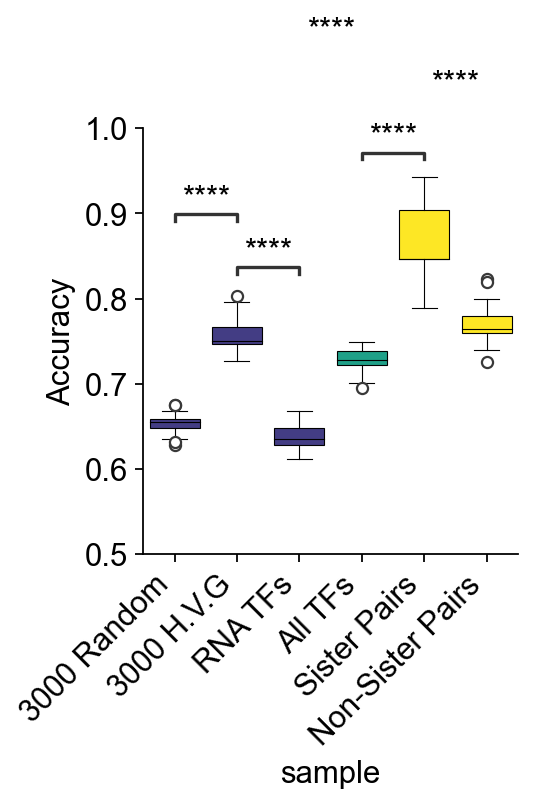

In [9]:
all_acc_sub = all_acc[all_acc['variable']=='ACC'].copy()
# all_acc_sub = all_acc_sub[all_acc_sub['sample'].isin(['rna','rna_tf','atac','atac_200'])].copy()

# sns.stripplot(x='sample',y='value',hue='variable',data = all_acc_sub,
#               size = 10,alpha = 0.3, jitter=1)

plt.figure(figsize=(3,3.5))
ax=plt.axes()
sns.boxplot(x='sample',y='value',data = all_acc_sub, ax=ax,palette=['#433d84','#433d84',"#433d84",'#1fa088','#fde725','#fde725'],
            boxprops=dict(edgecolor='black', linewidth=1/2),
            medianprops=dict(color='black', linewidth=1/2),
           whiskerprops=dict(color='black', linewidth=1/2),
           capprops=dict(color='black', linewidth=1/2), saturation=1,
           flierprops={'marker': 'o', 'markersize': 5, 'markerfacecolor': 'white','linewidth':1/2})

plt.xticks(rotation=45, ticks=list(range(6)), 
           labels=['3000 Random','3000 H.V.G','RNA TFs' ,'All TFs','Sister Pairs','Non-Sister Pairs'], ha='right')
plt.ylabel('Accuracy')
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.grid(False)

pairs=[("rna", "rna_tf"),("rna", "rna_random") ,('rna','multi'), ('atac','multi'), ('multi','multi_random')]
x='sample'
y='value'
annotator = Annotator(ax, pairs, data=all_acc_sub, x=x, y=y)
annotator.configure(test='Mann-Whitney', text_format
                    ='star', loc='inside', show_test_name=False)
annotator.apply_and_annotate()
plt.ylim(0.5,1)


# plt.savefig("./220724_plots/primary_model_accuracy_ALL.pdf")

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

rna vs. rna_tf: Mann-Whitney-Wilcoxon test two-sided, P_val:1.416e-09 U_stat=6.250e+02
rna_random vs. rna: Mann-Whitney-Wilcoxon test two-sided, P_val:1.416e-09 U_stat=0.000e+00
atac vs. multi: Mann-Whitney-Wilcoxon test two-sided, P_val:1.414e-09 U_stat=0.000e+00
multi vs. multi_random: Mann-Whitney-Wilcoxon test two-sided, P_val:1.411e-09 U_stat=6.250e+02
rna vs. multi: Mann-Whitney-Wilcoxon test two-sided, P_val:1.799e-09 U_stat=2.000e+00


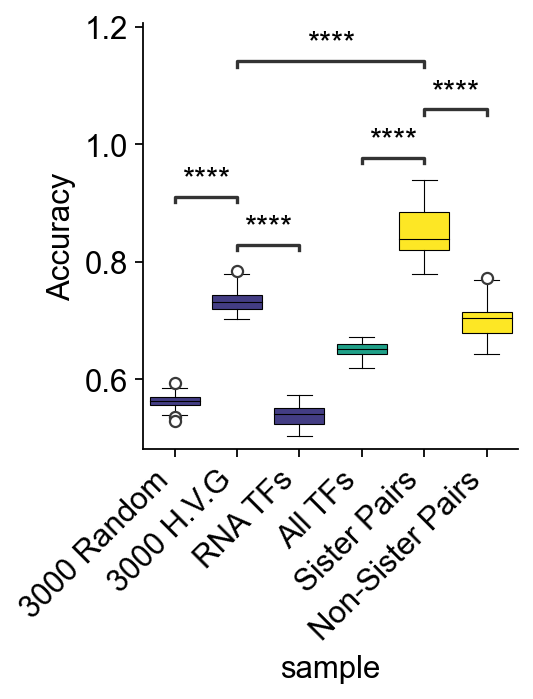

In [10]:
all_acc_sub = all_acc[all_acc['variable']=='F1-weighted'].copy()
# all_acc_sub = all_acc_sub[all_acc_sub['sample'].isin(['rna','rna_tf','atac','atac_200'])].copy()

# sns.stripplot(x='sample',y='value',hue='variable',data = all_acc_sub,
#               size = 10,alpha = 0.3, jitter=1)

plt.figure(figsize=(3,3.5))
ax=plt.axes()
sns.boxplot(x='sample',y='value',data = all_acc_sub, ax=ax,palette=['#433d84','#433d84',"#433d84",'#1fa088','#fde725','#fde725'],
            boxprops=dict(edgecolor='black', linewidth=1/2),
            medianprops=dict(color='black', linewidth=1/2),
           whiskerprops=dict(color='black', linewidth=1/2),
           capprops=dict(color='black', linewidth=1/2), saturation=1,
           flierprops={'marker': 'o', 'markersize': 5, 'markerfacecolor': 'white','linewidth':1/2})

plt.xticks(rotation=45, ticks=list(range(6)), 
           labels=['3000 Random','3000 H.V.G','RNA TFs' ,'All TFs','Sister Pairs','Non-Sister Pairs'], ha='right')
plt.ylabel('Accuracy')
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.grid(False)

pairs=[("rna", "rna_tf"),("rna", "rna_random") ,('rna','multi'), ('atac','multi'), ('multi','multi_random')]
x='sample'
y='value'
annotator = Annotator(ax, pairs, data=all_acc_sub, x=x, y=y)
annotator.configure(test='Mann-Whitney', text_format
                    ='star', loc='inside', show_test_name=False)
annotator.apply_and_annotate()
# plt.ylim(0.5,1)


# plt.savefig("./220724_plots/primary_model_f1w_ALL.pdf")

# Compare model architectures

In [11]:
atac_rf_acc = pd.read_csv("../compare_architectures/performance_metrics/tuned_model_rf_hsc.atac.r1&2_tfact_knnimputed20_all_fate_clone_size_1_subatac2fate_subsample_934_performance.csv",
                          index_col=0).melt()

atac_lr_acc = pd.read_csv("../compare_architectures/performance_metrics/tuned_model_lr_hsc.atac.r1&2_tfact_knnimputed20_all_fate_clone_size_1_subatac2fate_subsample_934_performance.csv",
                              index_col=0).melt()

atac_gbm_acc = pd.read_csv("../compare_architectures/performance_metrics/tuned_model_lightgbm_hsc.atac.r1&2_tfact_knnimputed20_all_fate_clone_size_1_subatac2fate_subsample_934_performance.csv",
                                index_col=0).melt()

rna_rf_acc = pd.read_csv("../compare_architectures/performance_metrics/tuned_model_rf_hsc.rna.r1&2_integrated_data_fate_clone_size_1_rna2fate_subsample_1520_performance.csv",
                          index_col=0).melt()

rna_lr_acc = pd.read_csv("../compare_architectures/performance_metrics/tuned_model_lr_hsc.rna.r1&2_integrated_data_fate_clone_size_1_rna2fate_subsample_1520_performance.csv",
                              index_col=0).melt()

rna_gbm_acc = pd.read_csv("../compare_architectures/performance_metrics/tuned_model_lightgbm_hsc.rna.r1&2_integrated_data_fate_clone_size_1_rna2fate_subsample_1520_performance.csv",
                                index_col=0).melt()


In [12]:
atac_rf_acc['sample'] = 'atac_rf'
atac_lr_acc['sample'] = 'atac_lr'
atac_gbm_acc['sample'] = 'atac_gbm'
rna_rf_acc['sample'] = 'rna_rf'
rna_lr_acc['sample'] = 'rna_lr'
rna_gbm_acc['sample'] = 'rna_gbm'

In [13]:
atac_acc= pd.concat((atac_lr_acc,atac_rf_acc, atac_gbm_acc))
rna_acc= pd.concat((rna_lr_acc,rna_rf_acc, rna_gbm_acc))

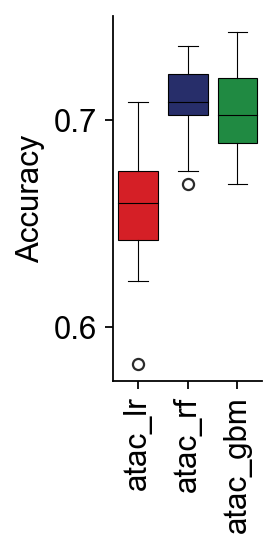

In [18]:
atac_acc_curr = atac_acc[atac_acc['variable']=='ACC'].copy()

plt.figure(figsize=(1.2,3))
ax=plt.axes()
sns.boxplot(x='sample',y='value',data = atac_acc_curr, ax=ax, palette=["#D51F26" ,"#272E6A", "#208A42", "#89288F", "#F47D2B"] ,
            boxprops=dict(edgecolor='black', linewidth=1/2),
            medianprops=dict(color='black', linewidth=1/2),
           whiskerprops=dict(color='black', linewidth=1/2),
           capprops=dict(color='black', linewidth=1/2), saturation=1,flierprops={'marker': 'o', 'markersize': 5, 'markerfacecolor': 'white','linewidth':1/2})
# plt.ylim(0.5,1)
plt.ylabel('Accuracy')
plt.xticks(rotation=90)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)


ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_locator(MaxNLocator(nbins=2))
plt.xlabel('')

plt.grid(False)
# plt.savefig("./221010_plots/atac_architectures_accuracy.pdf")

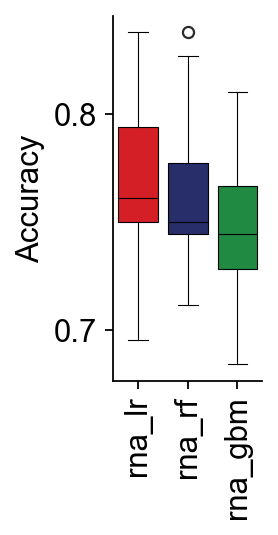

In [19]:
rna_acc_curr = rna_acc[rna_acc['variable']=='ACC'].copy()

plt.figure(figsize=(1.2,3))
ax=plt.axes()
sns.boxplot(x='sample',y='value',data = rna_acc_curr, ax=ax, palette=["#D51F26" ,"#272E6A", "#208A42", "#89288F", "#F47D2B"] ,
            boxprops=dict(edgecolor='black', linewidth=1/2),
            medianprops=dict(color='black', linewidth=1/2),
           whiskerprops=dict(color='black', linewidth=1/2),
           capprops=dict(color='black', linewidth=1/2), saturation=1,flierprops={'marker': 'o', 'markersize': 5, 'markerfacecolor': 'white','linewidth':1/2})
# plt.ylim(0.5,1)
plt.ylabel('Accuracy')
plt.xticks(rotation=90)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)


ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_locator(MaxNLocator(nbins=2))
plt.xlabel('')

plt.grid(False)
# plt.savefig("./221010_plots/rna_architectures_accuracy.pdf")

# Compare ATAC peak subsets

In [20]:
class_dict = {0: "Baso_Eos_Mast", 1: "Ery_Meg", 2: "Lym_pDC_Ccr7DC", 3: "Monocyte", 4: "Neutrophil", 5: "Prog"}

In [21]:
shap_dict = {}
test_dict = {}

## Plot performance metrics for peak subset models

In [22]:
atac_acc = pd.read_csv("../rna_atac/atac_performance_metrics/tuned_model_rf_hsc.atac.r1&2_tfact_knnimputed20_all_fate_clone_size_1_subatac2fate_subsample_934_performance.csv", index_col=0).melt()

atac_distal_acc = pd.read_csv("../chromvar_subsets/performance_metrics/full_models/tuned_model_rf_hsc.atac.r1&2_Distal_tfact_knnimputed20_all_fate_clone_size_1_subatac2fate_subsample_934_performance.csv",
                              index_col=0).melt()
atac_intronic_acc = pd.read_csv("../chromvar_subsets/performance_metrics/full_models/tuned_model_rf_hsc.atac.r1&2_Intronic_tfact_knnimputed20_all_fate_clone_size_1_subatac2fate_subsample_934_performance.csv",
                                index_col=0).melt()
atac_promoter_acc = pd.read_csv("../chromvar_subsets/performance_metrics/full_models/tuned_model_rf_hsc.atac.r1&2_Promoter_tfact_fate_clone_size_1_subatac2fate_subsample_934_performance.csv",
                                index_col=0).melt()
atac_exonic_acc = pd.read_csv("../chromvar_subsets/performance_metrics/full_models/tuned_model_rf_hsc.atac.r1&2_Exonic_tfact_knnimputed20_all_fate_clone_size_1_subatac2fate_subsample_934_performance.csv",
                              index_col=0).melt()



In [23]:
atac_acc['sample'] = 'All'
atac_distal_acc['sample'] = 'Distal'
atac_intronic_acc['sample'] = 'Intronic'
atac_promoter_acc['sample'] = 'Promoter'
atac_exonic_acc['sample'] = 'Exonic'
# multi_ctrl_acc['sample'] = 'multi_random'

In [24]:
all_acc= pd.concat((atac_acc,atac_distal_acc, atac_intronic_acc, atac_promoter_acc,atac_exonic_acc))
all_acc.variable.unique()

array(['MCC', 'ACC', 'F1-macro', 'F1-micro', 'F1-weighted', 'Kappa'],
      dtype=object)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

All vs. Promoter: Mann-Whitney-Wilcoxon test two-sided, P_val:8.107e-10 U_stat=6.250e+02
All vs. Exonic: Mann-Whitney-Wilcoxon test two-sided, P_val:8.000e-09 U_stat=6.100e+02


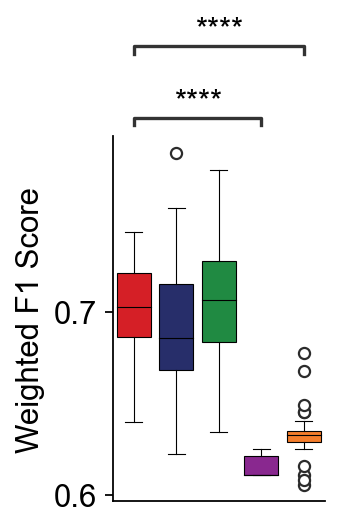

In [25]:
all_acc_curr = all_acc[all_acc['variable']=='F1-weighted'].copy()
# all_acc_sub = all_acc_sub[all_acc_sub['sample'].isin(['rna','rna_tf','atac','atac_200'])].copy()

# sns.stripplot(x='sample',y='value',hue='variable',data = all_acc_sub,
#               size = 10,alpha = 0.3, jitter=1)

plt.figure(figsize=(1.7,3))
ax=plt.axes()
sns.boxplot(x='sample',y='value',data = all_acc_curr, ax=ax, palette=["#D51F26" ,"#272E6A", "#208A42", "#89288F", "#F47D2B"] ,
            boxprops=dict(edgecolor='black', linewidth=1/2),
            medianprops=dict(color='black', linewidth=1/2),
           whiskerprops=dict(color='black', linewidth=1/2),
           capprops=dict(color='black', linewidth=1/2), saturation=1,flierprops={'marker': 'o', 'markersize': 5, 'markerfacecolor': 'white','linewidth':1/2})
# plt.ylim(0.5,1)
plt.ylabel('Weighted F1 Score')
plt.xticks([], rotation=90)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

pairs=[("All", "Promoter"), ("All", "Exonic")]
x='sample'
y='value'
annotator = Annotator(ax, pairs, data=all_acc_curr, x=x, y=y)
annotator.configure(test='Mann-Whitney', text_format
                    ='star', loc='outside', show_test_name=False)
annotator.apply_and_annotate()

ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_locator(MaxNLocator(nbins=2))
plt.xlabel('')

plt.grid(False)
plt.savefig("./220724_plots/chromvar_subsets_model_f1w_ATAC.pdf")

## Plot performance metrics for downsampled peak subset models

In [26]:
atac_distal_acc_sub = pd.read_csv("../chromvar_subsets/performance_metrics/subsampled_models/tuned_model_rf_hsc.atac.r1&2_Distal_subsample__tfact_knnimputed20_all_fate_clone_size_1_subatac2fate_subsample_934_performance.csv",
                              index_col=0).melt()
atac_intronic_acc_sub = pd.read_csv("../chromvar_subsets/performance_metrics/subsampled_models/tuned_model_rf_hsc.atac.r1&2_Intronic_subsample__tfact_knnimputed20_all_fate_clone_size_1_subatac2fate_subsample_934_performance.csv",
                                index_col=0).melt()
atac_promoter_acc_sub = pd.read_csv("../chromvar_subsets/performance_metrics/subsampled_models/tuned_model_rf_hsc.atac.r1&2_Promoter_subsample__tfact_knnimputed20_all_fate_clone_size_1_subatac2fate_subsample_934_performance.csv",
                                index_col=0).melt()
atac_exonic_acc_sub = pd.read_csv("../chromvar_subsets/performance_metrics/subsampled_models/tuned_model_rf_hsc.atac.r1&2_Exonic_subsample__tfact_knnimputed20_all_fate_clone_size_1_subatac2fate_subsample_934_performance.csv",
                              index_col=0).melt()



In [27]:
atac_distal_acc_sub['sample'] = 'Distal'
atac_intronic_acc_sub['sample'] = 'Intronic'
atac_promoter_acc_sub['sample'] = 'Promoter'
atac_exonic_acc_sub['sample'] = 'Exonic'
# multi_ctrl_acc['sample'] = 'multi_random'

In [28]:
all_acc_sub= pd.concat((atac_distal_acc_sub, atac_intronic_acc_sub, atac_promoter_acc_sub,atac_exonic_acc_sub))
all_acc_sub.variable.unique()

array(['MCC', 'ACC', 'F1-macro', 'F1-micro', 'F1-weighted', 'Kappa'],
      dtype=object)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Intronic vs. Promoter: Mann-Whitney-Wilcoxon test two-sided, P_val:1.234e-03 U_stat=4.795e+02
Distal vs. Promoter: Mann-Whitney-Wilcoxon test two-sided, P_val:4.456e-02 U_stat=4.165e+02
Intronic vs. Exonic: Mann-Whitney-Wilcoxon test two-sided, P_val:9.160e-05 U_stat=5.145e+02
Distal vs. Exonic: Mann-Whitney-Wilcoxon test two-sided, P_val:5.831e-03 U_stat=4.550e+02


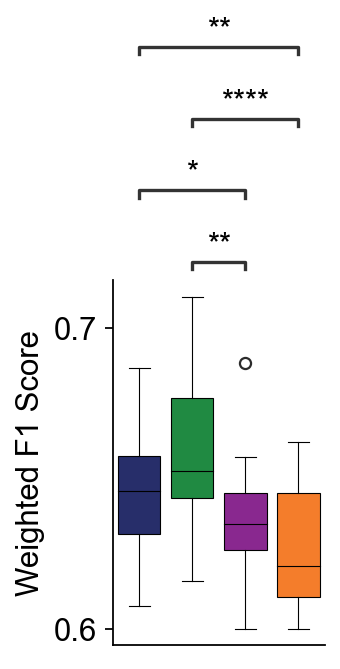

In [29]:
all_acc_curr_2 = all_acc_sub[all_acc_sub['variable']=='F1-weighted'].copy()

plt.figure(figsize=(1.7,3))
ax=plt.axes()
sns.boxplot(x='sample',y='value',data = all_acc_curr_2, ax=ax, palette=["#272E6A", "#208A42", "#89288F", "#F47D2B"] ,
            boxprops=dict(edgecolor='black', linewidth=1/2),
            medianprops=dict(color='black', linewidth=1/2),
           whiskerprops=dict(color='black', linewidth=1/2),
           capprops=dict(color='black', linewidth=1/2), saturation=1,flierprops={'marker': 'o', 'markersize': 5, 'markerfacecolor': 'white','linewidth':1/2})
# plt.ylim(0.5,1)
plt.ylabel('Weighted F1 Score')
plt.xticks([],rotation=45, ha='right')

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

pairs=[("Distal", "Promoter"), ("Distal", "Exonic"),("Intronic", "Promoter"), ("Intronic", "Exonic")]
x='sample'
y='value'
annotator = Annotator(ax, pairs, data=all_acc_curr_2, x=x, y=y)
annotator.configure(test='Mann-Whitney', text_format
                    ='star', loc='outside', show_test_name=False)
annotator.apply_and_annotate()
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_locator(MaxNLocator(nbins=1))
plt.xlabel('')

plt.grid(False)
# plt.savefig("./220724_plots/chromvar_subsets_model_f1w_ATAC_subsampling.pdf")

## Plot SHAP correlation heatmap

In [30]:
shap_dict['distal'] = sf_utils.shap_loader("../chromvar_subsets/shap_vals/shap_values_hsc.atac.r1&2_Distal_tfact_knnimputed20_all_fate_clone_size_1_subatac2fate_wo_unknown_subsample_934")
shap_dict['promoter'] = sf_utils.shap_loader("../chromvar_subsets/shap_vals/shap_values_hsc.atac.r1&2_Promoter_tfact_knnimputed20_all_fate_clone_size_1_subatac2fate_wo_unknown_subsample_934")
shap_dict['exonic'] = sf_utils.shap_loader("../chromvar_subsets/shap_vals/shap_values_hsc.atac.r1&2_Exonic_tfact_knnimputed20_all_fate_clone_size_1_subatac2fate_wo_unknown_subsample_934")
shap_dict['intronic'] = sf_utils.shap_loader("../chromvar_subsets/shap_vals/shap_values_hsc.atac.r1&2_Intronic_tfact_knnimputed20_all_fate_clone_size_1_subatac2fate_wo_unknown_subsample_934")
shap_dict['all'] = sf_utils.shap_loader("../chromvar_subsets/shap_vals/shap_values_hsc.atac.r1&2_tfact_knnimputed20_all_fate_clone_size_1_subatac2fate_wo_unknown_subsample_934")

In [31]:
shap_dict['distal'].shape

(6, 4670, 882)

In [32]:
test_dict['distal'] = pd.read_csv("../chromvar_subsets/test_data_mtx/X_test_hsc.atac.r1&2_Distal_tfact_knnimputed20_all_fate_clone_size_1_subatac2fate_wo_unknown_subsample_934.csv",
                                  index_col=0)
test_dict['promoter'] = pd.read_csv("../chromvar_subsets/test_data_mtx/X_test_hsc.atac.r1&2_Promoter_tfact_knnimputed20_all_fate_clone_size_1_subatac2fate_wo_unknown_subsample_934.csv",
                                  index_col=0)
test_dict['exonic'] = pd.read_csv("../chromvar_subsets/test_data_mtx/X_test_hsc.atac.r1&2_Exonic_tfact_knnimputed20_all_fate_clone_size_1_subatac2fate_wo_unknown_subsample_934.csv",
                                  index_col=0)
test_dict['intronic'] = pd.read_csv("../chromvar_subsets/test_data_mtx/X_test_hsc.atac.r1&2_Intronic_tfact_knnimputed20_all_fate_clone_size_1_subatac2fate_wo_unknown_subsample_934.csv",
                                  index_col=0)
test_dict['all'] = pd.read_csv("../rna_atac/test_data_mtx/X_test_hsc.atac.r1&2_tfact_knnimputed20_all_fate_clone_size_1_subatac2fate_wo_unknown_subsample_934.csv",
                                  index_col=0)

In [33]:
shap_obj = {}


for i in class_dict.keys():  #fate labels
    dict_curr = {}
    for j in shap_dict.keys():  #peak subset
        dict_curr[j] = shap.Explanation(shap_dict[j][i],
                                        data = test_dict[j].to_numpy(),
                                        feature_names=pd.Series(test_dict[j].columns),
                                        instance_names=pd.Series(test_dict[j].index))
    shap_obj[class_dict[i]] = dict_curr


In [34]:
df_master = {}
for fate in class_dict.values():
    print(fate)
    #get union top 20 features for each subset
    features_to_use = set()
    for i in shap_dict.keys():
        features_to_use = features_to_use.union(set(sf_utils.get_top_n_features(shap_obj[fate][i],num_ft=50)))


    features_to_use = np.array(list(features_to_use))


    #get shap vals for these features in a df
    for i,j in enumerate(shap_dict.keys()):
        if(i==0):
            df = pd.DataFrame(data=np.abs(shap_obj[fate][j].values).mean(axis=0),
                 index = shap_obj[fate][j].feature_names, columns=[j])
        else:
            df = df.merge(pd.DataFrame(data=np.abs(shap_obj[fate][j].values).mean(axis=0),
                 index = shap_obj[fate][j].feature_names, columns=[j]),
                         right_index=True, left_index=True, how='outer')
            # print(len(df))

    df = df.loc[features_to_use].copy()
    df_master[fate] = df

Baso_Eos_Mast
Ery_Meg
Lym_pDC_Ccr7DC
Monocyte
Neutrophil
Prog


In [35]:
np.corrcoef(df_master['Monocyte']['exonic'].values, df_master['Monocyte']['exonic'].values)

array([[nan, nan],
       [nan, nan]])

In [36]:
df_master_corr = {i:j.corr('spearman') for i,j in df_master.items()}

In [37]:
from functools import reduce

corr_mtx = reduce(lambda x, y: x.add(y, fill_value=0), df_master_corr.values())/len(df_master)

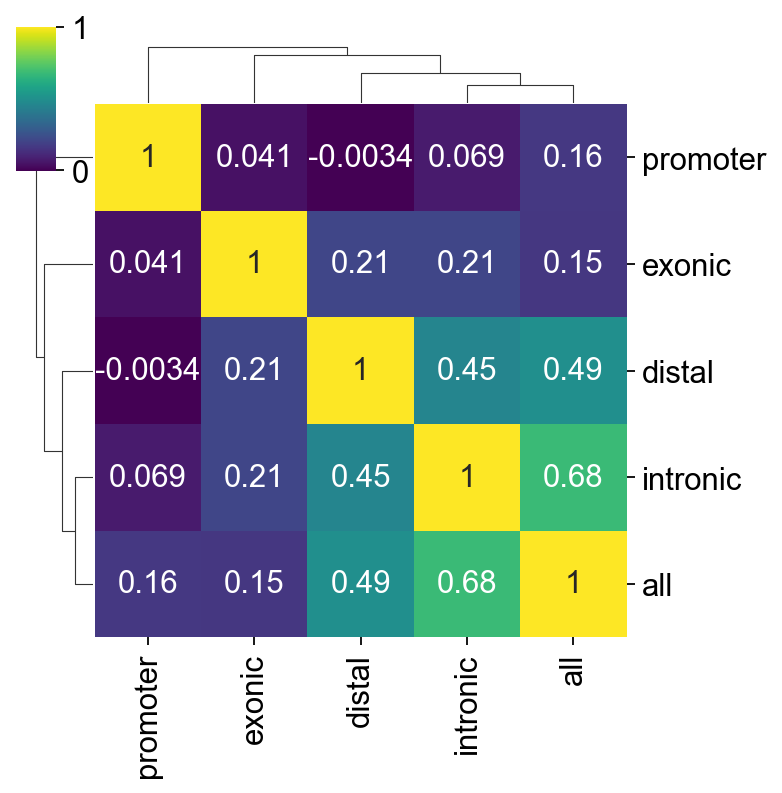

In [38]:
sns.clustermap(corr_mtx, dendrogram_ratio=0.1, figsize=(5,5), annot=True, cmap='viridis')
# plt.savefig("220724_plots/chromvar_subsets_shap_correlation.pdf")

## SHAP barplots

Text(0.5, 1.0, 'Neutrophils - Nfil3')

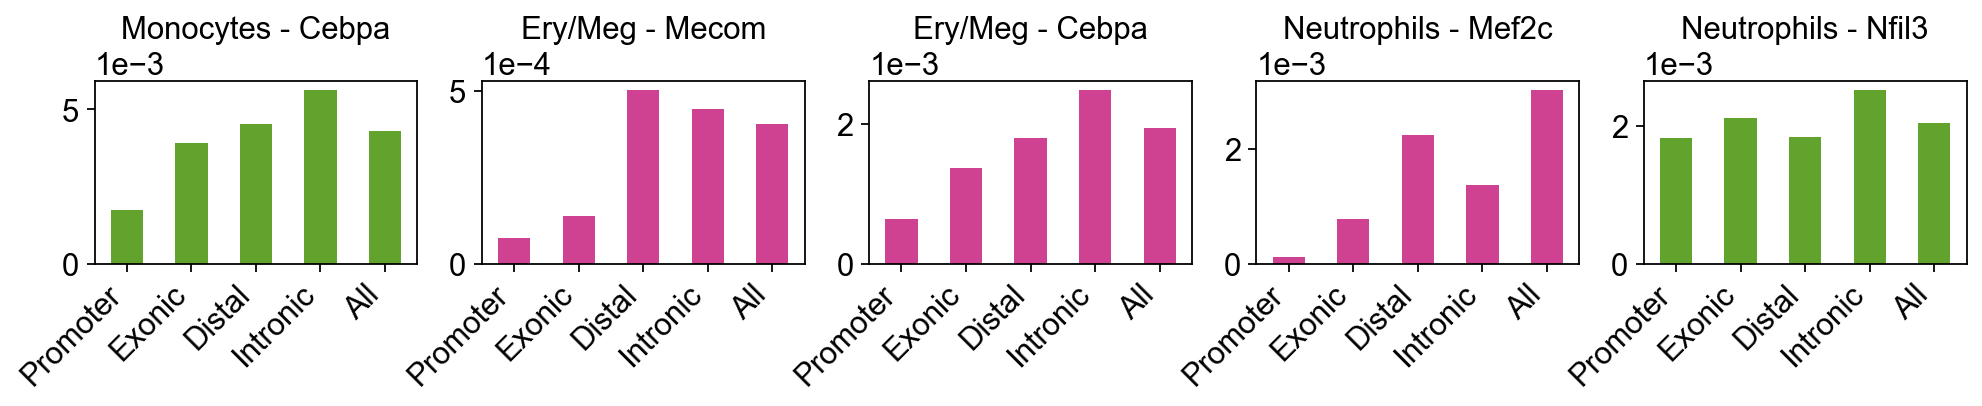

In [41]:
plt.figure(figsize=(15,1.5))
gs=GridSpec(1,5)

ax=plt.subplot(gs[0])
df_master['Monocyte'].loc['Cebpa-115',['promoter','exonic','distal','intronic','all']].plot(kind='bar',
                                                                                            color=sns.color_palette('PiYG').as_hex()[-1])
plt.grid(False)
plt.ticklabel_format(style='sci', axis='y',scilimits=(0,0))
plt.xticks(rotation=45,ha='right', ticks=range(5), labels = ['Promoter','Exonic','Distal','Intronic','All'])
plt.title('Monocytes - Cebpa')

ax=plt.subplot(gs[1])
df_master['Ery_Meg'].loc['Mecom-173',['promoter','exonic','distal','intronic','all']].plot(kind='bar',
                                                                                            color=sns.color_palette('PiYG').as_hex()[0])
plt.grid(False)
plt.ticklabel_format(style='sci', axis='y',scilimits=(0,0))
plt.xticks(rotation=45,ha='right', ticks=range(5), labels = ['Promoter','Exonic','Distal','Intronic','All'])
plt.title('Ery/Meg - Mecom')

ax=plt.subplot(gs[2])
df_master['Ery_Meg'].loc['Cebpa-115',['promoter','exonic','distal','intronic','all']].plot(kind='bar',
                                                                                            color=sns.color_palette('PiYG').as_hex()[0])
plt.grid(False)
plt.ticklabel_format(style='sci', axis='y',scilimits=(0,0))
plt.xticks(rotation=45,ha='right', ticks=range(5), labels = ['Promoter','Exonic','Distal','Intronic','All'])
plt.title('Ery/Meg - Cebpa')

ax=plt.subplot(gs[3])
df_master['Neutrophil'].loc['Mef2c-638',['promoter','exonic','distal','intronic','all']].plot(kind='bar',
                                                                                            color=sns.color_palette('PiYG').as_hex()[0])
plt.grid(False)
plt.ticklabel_format(style='sci', axis='y',scilimits=(0,0))
plt.xticks(rotation=45,ha='right', ticks=range(5), labels = ['Promoter','Exonic','Distal','Intronic','All'])
plt.title('Neutrophils - Mef2c')

ax=plt.subplot(gs[4])
df_master['Neutrophil'].loc['Nfil3-138',['promoter','exonic','distal','intronic','all']].plot(kind='bar',
                                                                                            color=sns.color_palette('PiYG').as_hex()[-1])
plt.grid(False)
plt.ticklabel_format(style='sci', axis='y',scilimits=(0,0))
plt.xticks(rotation=45,ha='right', ticks=range(5), labels = ['Promoter','Exonic','Distal','Intronic','All'])
plt.title('Neutrophils - Nfil3')

# plt.savefig("./220724_plots/examples_of_shap.pdf")

## Save data for SHAP heatmaps

In [57]:
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
from scipy.cluster.hierarchy import fcluster
from scipy.spatial import distance
from scipy.cluster import hierarchy

In [52]:
adata_all = sc.read_h5ad("/scratch/smlab/lsk_atac_reanalysis/atac_analysis/output_files/lsk_tf_mtx.h5ad")
adata_promoter = sc.read_h5ad("/scratch/smlab/lsk_atac_reanalysis/atac_analysis/output_files/Promoter_lsk_tf_mtx.h5ad")
adata_intronic = sc.read_h5ad("/scratch/smlab/lsk_atac_reanalysis/atac_analysis/output_files/Intronic_lsk_tf_mtx.h5ad")
adata_distal = sc.read_h5ad("/scratch/smlab/lsk_atac_reanalysis/atac_analysis/output_files/Distal_lsk_tf_mtx.h5ad")
adata_exonic = sc.read_h5ad("/scratch/smlab/lsk_atac_reanalysis/atac_analysis/output_files/Exonic_lsk_tf_mtx.h5ad")

In [79]:
adata_all.var.index = adata_all.var['features'].values
adata_promoter.var.index = adata_promoter.var['features'].values
adata_intronic.var.index = adata_intronic.var['features'].values
adata_distal.var.index = adata_distal.var['features'].values
adata_exonic.var.index = adata_exonic.var['features'].values

In [54]:
ft_list = set()
for i in df_master.keys():
    ft_list = ft_list.union(df_master[i].index[~df_master[i].isnull().any(axis=1)])
    
print(len(ft_list))

304


In [43]:
clone_table = pd.read_csv("../../munich_transfer/hsc.rna&atac.r1&2_master_v2.csv")

In [44]:
clone_table.fate.unique()

array(['no_fate_cells', 'Unk_3', 'Unk_2', 'Mono', 'Neutro', 'MPP/GMP',
       'MPP', 'uns', 'MEP', 'Unk_1', 'Ery/Meg', 'Ccr7_DC',
       'Baso/Eos/Mast', 'pDC', 'Lym'], dtype=object)

In [45]:
clone_table['fate_simple'] = clone_table['fate']

In [46]:
clone_table.loc[clone_table['fate'].isin(['MPP/GMP',
       'MPP', 'MEP']), 'fate_simple'] = 'Progenitors'

clone_table.loc[clone_table['fate'].isin(['Lym',
       'pDC', 'Ccr7_DC']), 'fate_simple'] = 'Lym_pDC_Ccr7DC'

In [47]:
clone_table = clone_table[(clone_table['day']=='d2') & (clone_table['assay']=='atac') 
            & (clone_table['fate_simple'].isin(['Mono', 'Neutro', 'Progenitors', 'Ery/Meg', 'Lym_pDC_Ccr7DC',
       'Baso/Eos/Mast']))].copy()

In [48]:
clone_table['cell.bc'] = clone_table['cell.bc'].apply(lambda x:x.replace("-atac-",'-ATAC-'))

In [49]:
clone_table.index = clone_table['cell.bc']

In [80]:
adata_all_sub = adata_all[adata_all.obs_names.isin(clone_table['cell.bc'])]
adata_all_sub = adata_all_sub[:,adata_all_sub.var_names.isin(ft_list)]
adata_all_sub = pd.DataFrame(adata_all_sub.X.todense(), index=adata_all_sub.obs_names, columns=adata_all_sub.var_names)
adata_all_sub = adata_all_sub.merge(clone_table[['fate_simple']], right_index=True, left_index=True).copy()
adata_all_sub = adata_all_sub.groupby('fate_simple').mean().T

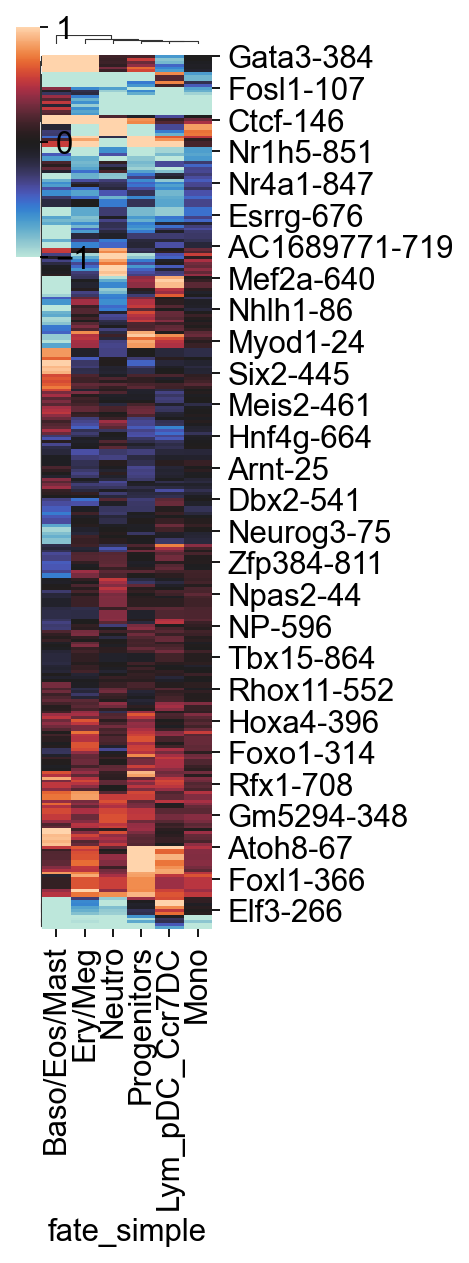

In [84]:
correlations_array = np.asarray(adata_all_sub)

metric = "euclidean"
row_linkage = hierarchy.linkage(
    distance.pdist(correlations_array, metric=metric), method='average')

col_linkage = hierarchy.linkage(
    distance.pdist(correlations_array.T, metric=metric), method='average')
res = sns.clustermap(adata_all_sub, row_linkage=row_linkage, col_linkage=col_linkage, 
                figsize=(3,8),center=0, vmin=-1, vmax=1, dendrogram_ratio=0.01)


adata_all_sub = adata_all_sub.iloc[res.dendrogram_row.reordered_ind]
adata_all_sub = adata_all_sub.iloc[:,res.dendrogram_col.reordered_ind]


adata_all_sub.to_csv("./heatmap_data/cv_all_matrix.csv")

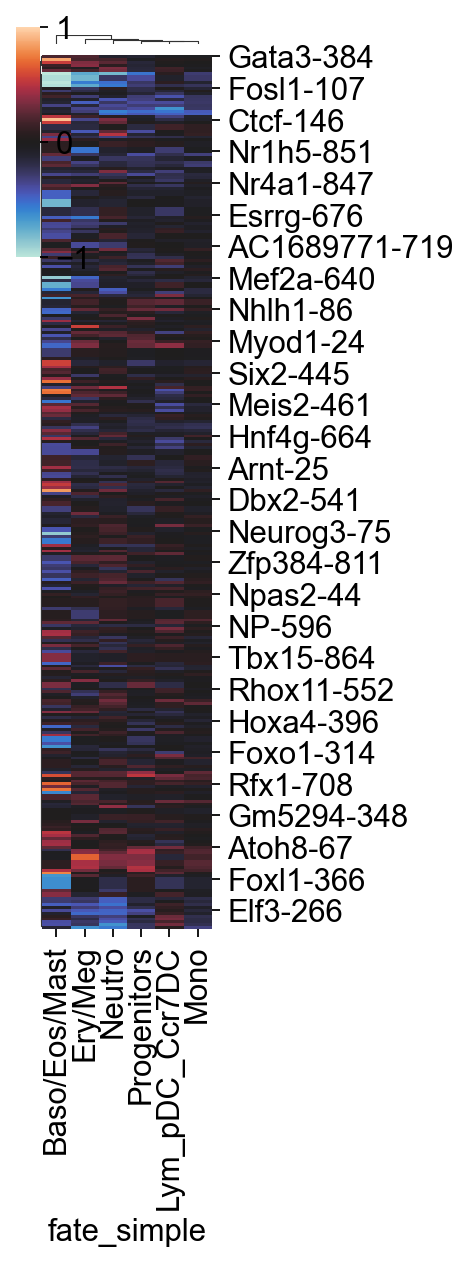

In [86]:
adata_all_sub = adata_promoter[adata_promoter.obs_names.isin(clone_table['cell.bc'])]
adata_all_sub = adata_all_sub[:,adata_all_sub.var_names.isin(ft_list)]
adata_all_sub = pd.DataFrame(adata_all_sub.X.todense(), index=adata_all_sub.obs_names, columns=adata_all_sub.var_names)
adata_all_sub = adata_all_sub.merge(clone_table[['fate_simple']], right_index=True, left_index=True).copy()
adata_all_sub = adata_all_sub.groupby('fate_simple').mean().T


res = sns.clustermap(adata_all_sub, row_linkage=row_linkage, col_linkage=col_linkage, 
                figsize=(3,8),center=0, vmin=-1, vmax=1, dendrogram_ratio=0.01)

adata_all_sub = adata_all_sub.iloc[res.dendrogram_row.reordered_ind]
adata_all_sub = adata_all_sub.iloc[:,res.dendrogram_col.reordered_ind]


# adata_all_sub.to_csv("./heatmap_data/cv_promoter_matrix.csv")

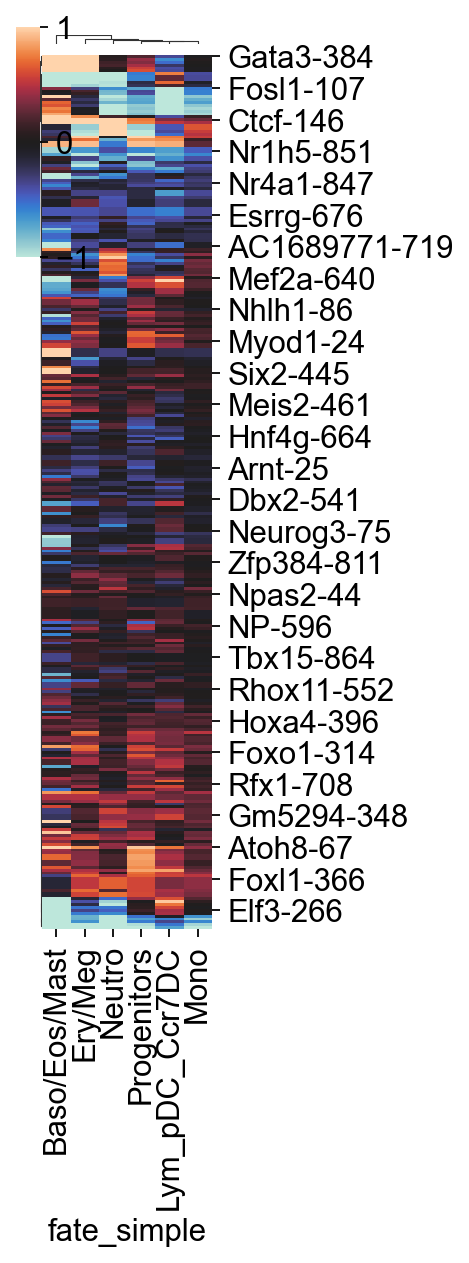

In [90]:
adata_all_sub = adata_distal[adata_distal.obs_names.isin(clone_table['cell.bc'])]
adata_all_sub = adata_all_sub[:,adata_all_sub.var_names.isin(ft_list)]
adata_all_sub = pd.DataFrame(adata_all_sub.X.todense(), index=adata_all_sub.obs_names, columns=adata_all_sub.var_names)
adata_all_sub = adata_all_sub.merge(clone_table[['fate_simple']], right_index=True, left_index=True).copy()
adata_all_sub = adata_all_sub.groupby('fate_simple').mean().T


res = sns.clustermap(adata_all_sub, row_linkage=row_linkage, col_linkage=col_linkage, 
                figsize=(3,8),center=0, vmin=-1, vmax=1, dendrogram_ratio=0.01)

adata_all_sub = adata_all_sub.iloc[res.dendrogram_row.reordered_ind]
adata_all_sub = adata_all_sub.iloc[:,res.dendrogram_col.reordered_ind]


# adata_all_sub.to_csv("./heatmap_data/cv_distal_matrix.csv")

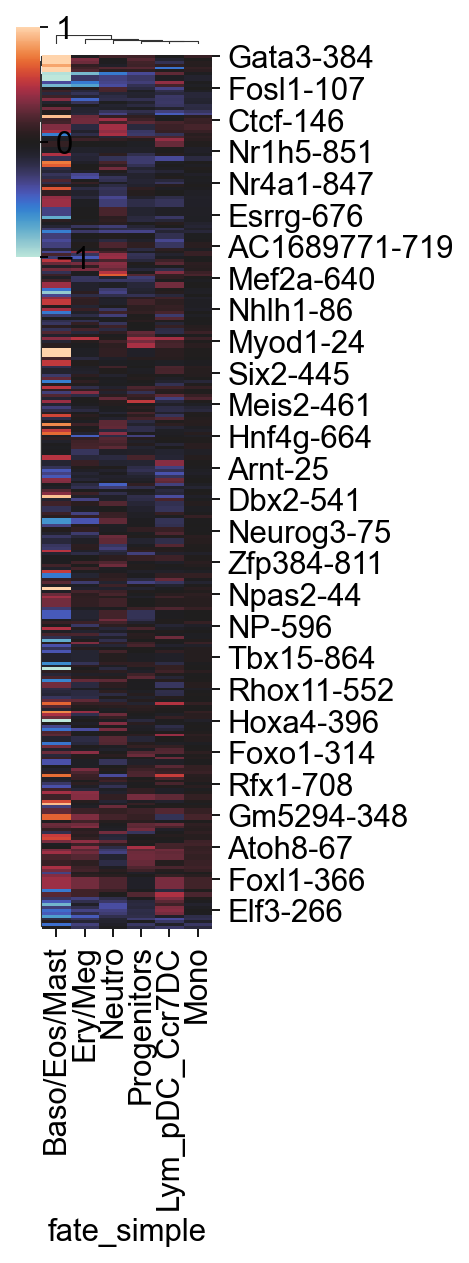

In [91]:
adata_all_sub = adata_exonic[adata_exonic.obs_names.isin(clone_table['cell.bc'])]
adata_all_sub = adata_all_sub[:,adata_all_sub.var_names.isin(ft_list)]
adata_all_sub = pd.DataFrame(adata_all_sub.X.todense(), index=adata_all_sub.obs_names, columns=adata_all_sub.var_names)
adata_all_sub = adata_all_sub.merge(clone_table[['fate_simple']], right_index=True, left_index=True).copy()
adata_all_sub = adata_all_sub.groupby('fate_simple').mean().T


res = sns.clustermap(adata_all_sub, row_linkage=row_linkage, col_linkage=col_linkage, 
                figsize=(3,8),center=0, vmin=-1, vmax=1, dendrogram_ratio=0.01)

adata_all_sub = adata_all_sub.iloc[res.dendrogram_row.reordered_ind]
adata_all_sub = adata_all_sub.iloc[:,res.dendrogram_col.reordered_ind]


# adata_all_sub.to_csv("./heatmap_data/cv_exonic_matrix.csv")

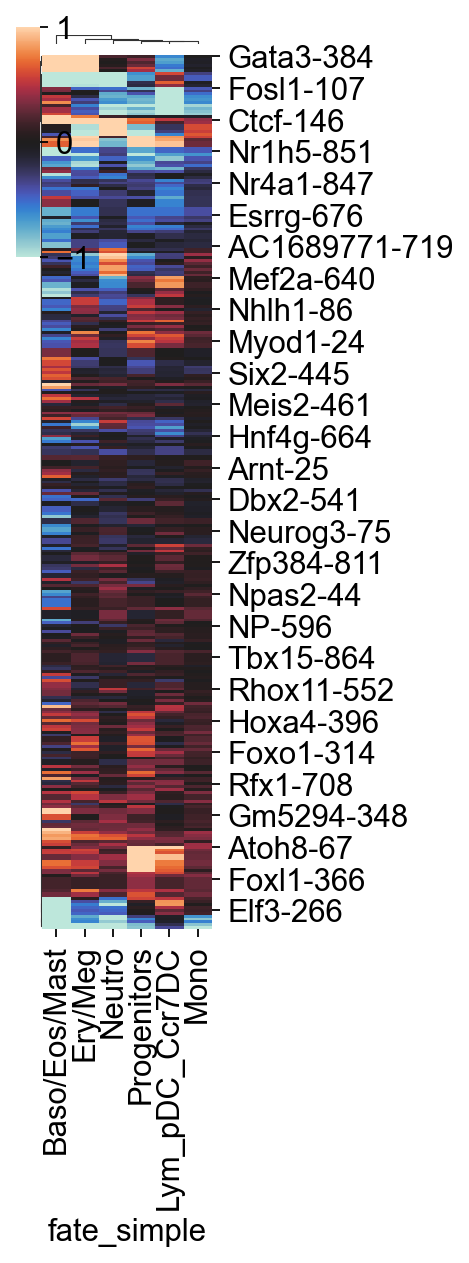

In [92]:
adata_all_sub = adata_intronic[adata_intronic.obs_names.isin(clone_table['cell.bc'])]
adata_all_sub = adata_all_sub[:,adata_all_sub.var_names.isin(ft_list)]
adata_all_sub = pd.DataFrame(adata_all_sub.X.todense(), index=adata_all_sub.obs_names, columns=adata_all_sub.var_names)
adata_all_sub = adata_all_sub.merge(clone_table[['fate_simple']], right_index=True, left_index=True).copy()
adata_all_sub = adata_all_sub.groupby('fate_simple').mean().T


res = sns.clustermap(adata_all_sub, row_linkage=row_linkage, col_linkage=col_linkage, 
                figsize=(3,8),center=0, vmin=-1, vmax=1, dendrogram_ratio=0.01)

adata_all_sub = adata_all_sub.iloc[res.dendrogram_row.reordered_ind]
adata_all_sub = adata_all_sub.iloc[:,res.dendrogram_col.reordered_ind]


# adata_all_sub.to_csv("./heatmap_data/cv_intronic_matrix.csv")